In [118]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Summary

This workbook includes notes from chapter three of the *Fundamentals of Machine Learning for Predictive Data Analytics* and a worked example from data that I am currently using to develop an ML model.

### Getting to Know the Data

In previous chapters the authors have described the process of compiling data from multiple sources into a single tabular format which they refer to as the Analytics Base Table (ABT). From the ABT, the goal is to explore each input feature in detail, to understand more about the data prior to applying a model to determine an output feature. 

I'm going to work through an example of some of the key principles using data from alphavantage which is an API focusing on US equities. You can find more information on the API here: https://www.alphavantage.co/documentation/

In [119]:
import requests
import pandas as pd
import pickle
import os
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
import time
import numpy as np
import plotly.io as pio
from tqdm import tqdm
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sn
from sklearn.cluster import KMeans
import warnings


df_sp500 = pd.read_csv('sp500_tickers.csv')
tickers = df_sp500['Symbol'].values
df = pd.read_pickle('sp500_overview.pkl')
df

,Symbol,AssetType,Name,Description,CIK,Exchange,Currency,Country,Sector,Industry,...,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,50DayMovingAverage,200DayMovingAverage,SharesOutstanding,DividendDate,ExDividendDate
0,BAC,Common Stock,Bank of America Corporation,The Bank of America Corporation is an American...,70858,NYSE,USD,USA,FINANCE,NATIONAL COMMERCIAL BANKS,...,-,-,1.396,49.87,32.96,39.03,43.16,8056880000,2022-06-24,2022-06-02
0,AAPL,Common Stock,Apple Inc,Apple Inc. is an American multinational techno...,320193,NASDAQ,USD,USA,TECHNOLOGY,ELECTRONIC COMPUTERS,...,5.94,17.23,1.195,182.44,122.43,161.84,159.58,16185200000,2022-05-12,2022-05-06
0,MSFT,Common Stock,Microsoft Corporation,Microsoft Corporation is an American multinati...,789019,NASDAQ,USD,USA,TECHNOLOGY,SERVICES-PREPACKAGED SOFTWARE,...,9.64,18.84,0.908,348.14,241.03,286.18,303.92,7507980000,2022-06-09,2022-05-18
0,GOOG,Common Stock,Alphabet Inc,Alphabet Inc. is an American multinational con...,1652044,NASDAQ,USD,USA,TECHNOLOGY,"SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING...",...,5.07,13.42,1.132,3042,2127.46,2542.12,2747.59,313376000,None,None
0,GOOGL,Common Stock,Alphabet Inc,Alphabet Inc. is an American multinational con...,1652044,NASDAQ,USD,USA,TECHNOLOGY,"SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING...",...,5.07,13.42,1.132,3030.93,2115.93,2542.24,2741.46,300764000,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,ALK,Common Stock,Alaska Air Group Inc,Alaska Air Group is an airline holding company...,766421,NYSE,USD,USA,ENERGY & TRANSPORTATION,"AIR TRANSPORTATION, SCHEDULED",...,0.989,6.3,1.441,70.9,43.39,53.26,54.64,126092000,2020-03-05,2020-02-14
0,PENN,Common Stock,Penn National Gaming Inc,"Penn National Gaming, Inc. is an American oper...",921738,NASDAQ,USD,USA,REAL ESTATE & CONSTRUCTION,HOTELS & MOTELS,...,2.623,10.86,2.345,86.4,28.3,38.06,54.53,166803000,None,None
0,IPGP,Common Stock,IPG Photonics Corporation,IPG Photonics is a manufacturer of fiber lasers.,1111928,NASDAQ,USD,USA,MANUFACTURING,SEMICONDUCTORS & RELATED DEVICES,...,2.564,8.42,1.363,220.51,90.51,104.25,145.98,51873000,2012-12-28,2012-12-19
0,PVH,Common Stock,PVH Corp,"PVH Corp., formerly known as the Phillips-Van ...",78239,NYSE,USD,USA,MANUFACTURING,"MEN'S & BOYS' FURNISHGS, WORK CLOTHG, & ALLIED...",...,0.779,5.11,2.078,125.32,62.21,74.95,98.01,67522000,2022-06-29,2022-06-07


Exploring the columns in the dataframe and removing some columns out based on domain expertise. 

In [120]:
df.columns

Index(['Symbol', 'AssetType', 'Name', 'Description', 'CIK', 'Exchange',
       'Currency', 'Country', 'Sector', 'Industry', 'Address', 'FiscalYearEnd',
       'LatestQuarter', 'MarketCapitalization', 'EBITDA', 'PERatio',
       'PEGRatio', 'BookValue', 'DividendPerShare', 'DividendYield', 'EPS',
       'RevenuePerShareTTM', 'ProfitMargin', 'OperatingMarginTTM',
       'ReturnOnAssetsTTM', 'ReturnOnEquityTTM', 'RevenueTTM',
       'GrossProfitTTM', 'DilutedEPSTTM', 'QuarterlyEarningsGrowthYOY',
       'QuarterlyRevenueGrowthYOY', 'AnalystTargetPrice', 'TrailingPE',
       'ForwardPE', 'PriceToSalesRatioTTM', 'PriceToBookRatio', 'EVToRevenue',
       'EVToEBITDA', 'Beta', '52WeekHigh', '52WeekLow', '50DayMovingAverage',
       '200DayMovingAverage', 'SharesOutstanding', 'DividendDate',
       'ExDividendDate'],
      dtype='object')

In [121]:
keep_cols = ['Symbol', 'MarketCapitalization', 'EBITDA', 'PERatio',
       'PEGRatio', 'BookValue', 'DividendPerShare', 'DividendYield', 'EPS',
       'RevenuePerShareTTM', 'ProfitMargin', 'OperatingMarginTTM',
       'ReturnOnAssetsTTM', 'ReturnOnEquityTTM', 'RevenueTTM',
       'GrossProfitTTM', 'DilutedEPSTTM', 'QuarterlyEarningsGrowthYOY',
       'QuarterlyRevenueGrowthYOY','TrailingPE',
       'ForwardPE', 'PriceToSalesRatioTTM', 'PriceToBookRatio', 'EVToRevenue',
       'EVToEBITDA', 'Beta', '200DayMovingAverage']

df = df[keep_cols]
df

,Symbol,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,DividendPerShare,DividendYield,EPS,RevenuePerShareTTM,...,QuarterlyEarningsGrowthYOY,QuarterlyRevenueGrowthYOY,TrailingPE,ForwardPE,PriceToSalesRatioTTM,PriceToBookRatio,EVToRevenue,EVToEBITDA,Beta,200DayMovingAverage
0,BAC,272805970000,None,9.64,4.015,29.7,0.81,0.0248,3.514,11.04,...,-0.07,-0.06,9.64,10.44,2.958,1.159,-,-,1.396,43.16
0,AAPL,2226921669000,130633998000,22.42,2.489,4.158,0.88,0.0067,6.14,23.47,...,0.086,0.086,22.42,22.57,5.77,32.98,5.94,17.23,1.195,159.58
0,MSFT,1900569952000,94982996000,28.32,1.743,20.24,2.3,0.0095,8.94,25.64,...,0.094,0.184,28.32,23.58,9.83,11.66,9.64,18.84,0.908,303.92
0,GOOG,1437188227000,95841001000,19.77,0.798,385.58,0,0,110.58,406.89,...,-0.063,0.23,19.77,19.8,5.32,5.83,5.07,13.42,1.132,2747.59
0,GOOGL,1456856760000,95841001000,19.96,0.795,385.58,0,0,110.58,406.89,...,-0.063,0.23,19.96,19.72,5.39,5.8,5.07,13.42,1.132,2741.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,ALK,5812841000,467000000,12.62,1.3,28.84,0,0,3.654,56.26,...,0.486,1.109,12.62,10.92,0.823,1.615,0.989,6.3,1.441,54.64
0,PENN,5302668000,1563200000,14.38,-15.89,24.0,0,0,2.21,38.28,...,-0.473,0.227,14.38,13.12,0.856,1.28,2.623,10.86,2.345,54.53
0,IPGP,5191928000,454365000,19.21,2.52,51.52,0,0,5.21,27.9,...,0.04,0.071,19.21,19.57,3.496,1.916,2.564,8.42,1.363,145.98
0,PVH,4354468000,1275100000,4.867,0.569,77.17,0.037,0.0023,13.25,129.3,...,2.969,0.163,4.867,7.08,0.476,0.836,0.779,5.11,2.078,98.01


After we have our data, we can start to build a data quality report that is comprised of the following measures:

* Count
* % Miss
* Cardinality
* Min
* Quartiles
* Mean
* Median
* Max
* Standard Deviation

Pandas has some built in functions that makes this pretty easy, for example:

First we start by calculating missing data per column. This API adds "None" to anything that does not have data. Lets convert None to NaN and then check on missing values.

In [122]:
# convert the columns after the stock symbol column to numeric
df[df.columns.tolist()[1:]] = df[df.columns.tolist()[1:]].apply(pd.to_numeric,errors='coerce')
df

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Symbol,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,DividendPerShare,DividendYield,EPS,RevenuePerShareTTM,...,QuarterlyEarningsGrowthYOY,QuarterlyRevenueGrowthYOY,TrailingPE,ForwardPE,PriceToSalesRatioTTM,PriceToBookRatio,EVToRevenue,EVToEBITDA,Beta,200DayMovingAverage
0,BAC,272805970000,NaN,9.640,4.015,29.700,0.810,0.0248,3.514,11.040,...,-0.070,-0.060,9.640,10.44,2.958,1.159,NaN,NaN,1.396,43.16
0,AAPL,2226921669000,1.306340e+11,22.420,2.489,4.158,0.880,0.0067,6.140,23.470,...,0.086,0.086,22.420,22.57,5.770,32.980,5.940,17.23,1.195,159.58
0,MSFT,1900569952000,9.498300e+10,28.320,1.743,20.240,2.300,0.0095,8.940,25.640,...,0.094,0.184,28.320,23.58,9.830,11.660,9.640,18.84,0.908,303.92
0,GOOG,1437188227000,9.584100e+10,19.770,0.798,385.580,0.000,0.0000,110.580,406.890,...,-0.063,0.230,19.770,19.80,5.320,5.830,5.070,13.42,1.132,2747.59
0,GOOGL,1456856760000,9.584100e+10,19.960,0.795,385.580,0.000,0.0000,110.580,406.890,...,-0.063,0.230,19.960,19.72,5.390,5.800,5.070,13.42,1.132,2741.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,ALK,5812841000,4.670000e+08,12.620,1.300,28.840,0.000,0.0000,3.654,56.260,...,0.486,1.109,12.620,10.92,0.823,1.615,0.989,6.30,1.441,54.64
0,PENN,5302668000,1.563200e+09,14.380,-15.890,24.000,0.000,0.0000,2.210,38.280,...,-0.473,0.227,14.380,13.12,0.856,1.280,2.623,10.86,2.345,54.53
0,IPGP,5191928000,4.543650e+08,19.210,2.520,51.520,0.000,0.0000,5.210,27.900,...,0.040,0.071,19.210,19.57,3.496,1.916,2.564,8.42,1.363,145.98
0,PVH,4354468000,1.275100e+09,4.867,0.569,77.170,0.037,0.0023,13.250,129.300,...,2.969,0.163,4.867,7.08,0.476,0.836,0.779,5.11,2.078,98.01


In [123]:
# now lets check how many are non-null meaning not missing.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502 entries, 0 to 0
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Symbol                      502 non-null    object 
 1   MarketCapitalization        502 non-null    int64  
 2   EBITDA                      472 non-null    float64
 3   PERatio                     485 non-null    float64
 4   PEGRatio                    498 non-null    float64
 5   BookValue                   499 non-null    float64
 6   DividendPerShare            502 non-null    float64
 7   DividendYield               502 non-null    float64
 8   EPS                         502 non-null    float64
 9   RevenuePerShareTTM          502 non-null    float64
 10  ProfitMargin                502 non-null    float64
 11  OperatingMarginTTM          502 non-null    float64
 12  ReturnOnAssetsTTM           502 non-null    float64
 13  ReturnOnEquityTTM           502 non-n

It looks like we are pretty good on missing values - the column EVToEBITDA looks like it has the largest amount of NANs at 502-452 = 50 but, but that is still within the acceptable range. Now using the pandas describe value we can get descriptive stats on the columns. 

In [124]:
df_describe = df.describe().T
df_describe

,count,mean,std,min,25%,50%,75%,max
MarketCapitalization,502.0,7.112939e+10,1.784321e+11,4.168920e+09,1.626963e+10,2.814156e+10,6.021368e+10,2.226922e+12
EBITDA,472.0,5.990185e+09,1.191900e+10,7.700000e+06,1.318900e+09,2.647768e+09,5.516650e+09,1.306340e+11
PERatio,485.0,2.792045e+01,2.838480e+01,2.395000e+00,1.362000e+01,2.096000e+01,3.175000e+01,3.915200e+02
PEGRatio,498.0,4.287578e+00,3.889102e+01,-1.587200e+02,1.166500e+00,1.813000e+00,2.969250e+00,8.442000e+02
BookValue,499.0,3.947654e+01,5.740519e+01,-7.178000e+01,1.383500e+01,2.705000e+01,4.649000e+01,8.222400e+02
DividendPerShare,502.0,1.849741e+00,1.998272e+00,0.000000e+00,2.512500e-01,1.445000e+00,2.680000e+00,1.727000e+01
DividendYield,502.0,1.792789e-02,1.480349e-02,0.000000e+00,4.825000e-03,1.680000e-02,2.832500e-02,8.770000e-02
EPS,502.0,8.362424e+00,1.982478e+01,-2.079000e+01,2.762000e+00,5.215000e+00,8.727500e+00,3.732000e+02
RevenuePerShareTTM,502.0,7.749243e+01,1.743023e+02,2.733000e+00,2.102750e+01,3.618000e+01,7.180750e+01,2.651230e+03
ProfitMargin,502.0,1.538496e-01,2.088358e-01,-2.687000e+00,8.202500e-02,1.330000e-01,2.200000e-01,1.133000e+00


Now we can measure cardinality by finding the unique values and dividing by the total rows. Given that these are continious variables, we expect uniquness, and the single categorical value which is the Symbol column will be removed during the model phase.

In [125]:
df.apply(pd.Series.nunique)/502

Symbol                        1.000000
MarketCapitalization          1.000000
EBITDA                        0.928287
PERatio                       0.926295
PEGRatio                      0.916335
BookValue                     0.970120
DividendPerShare              0.561753
DividendYield                 0.515936
EPS                           0.916335
RevenuePerShareTTM            0.968127
ProfitMargin                  0.697211
OperatingMarginTTM            0.649402
ReturnOnAssetsTTM             0.747012
ReturnOnEquityTTM             0.699203
RevenueTTM                    0.990040
GrossProfitTTM                0.986056
DilutedEPSTTM                 0.916335
QuarterlyEarningsGrowthYOY    0.856574
QuarterlyRevenueGrowthYOY     0.649402
TrailingPE                    0.926295
ForwardPE                     0.792829
PriceToSalesRatioTTM          0.948207
PriceToBookRatio              0.916335
EVToRevenue                   0.894422
EVToEBITDA                    0.818725
Beta                     

The authors recommend checking distribution types for each input feature, evaluating outliers with plots like box plots, and checking the relationships between features with a scatter plot matrix. I start with a distribution plot, and via the distribution plot we can see that there are outliers worth exploring. 

In [126]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math


plt_cols = df.columns.tolist()[1:]
rows = int(math.ceil((len(df.columns.tolist()[1:]))))
fig = make_subplots(rows=rows, 
                    cols=1,
                    subplot_titles=plt_cols)

for i in range(1,len(plt_cols)):    
    current_col = plt_cols[i]    
    fig.add_trace(
        go.Histogram(x=df[current_col]),
        row = i+1, col = 1
    )

fig.update_layout(height=5000, width=800,showlegend=False)
fig.show()

The first thing to look for on the distributions above is any multi-modal distribution, nothing jumps out here. Beyond that knowing the distribution type is good. Anything that does not have a normal distribution may not be a good fit for z-score normalization. 

There are quite a few features that look like they do not have a normal distirbution, so we'll have to take a closer look at those during feature scaling. 

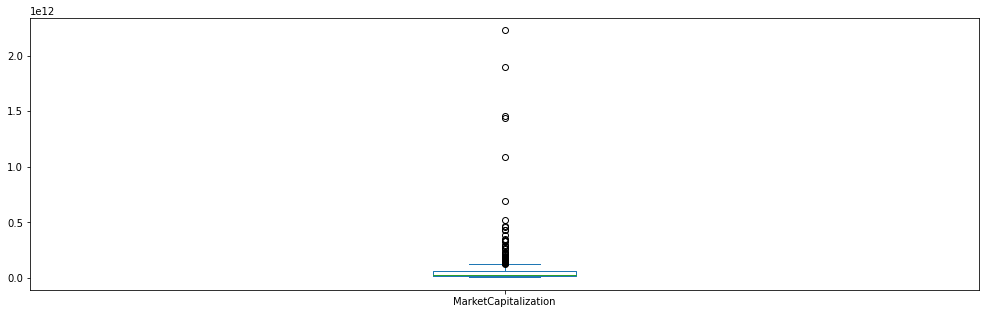

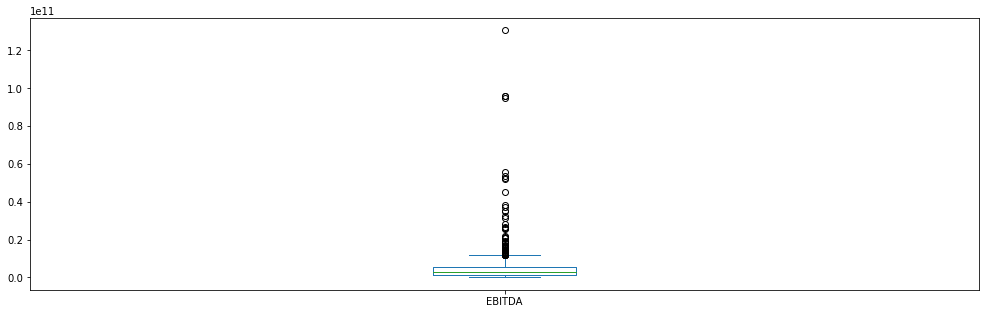

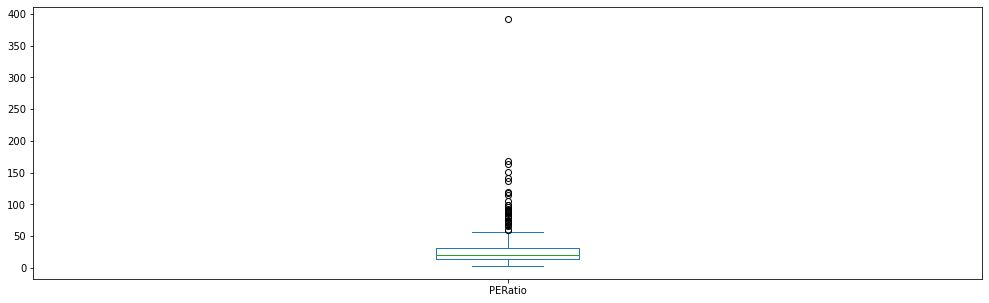

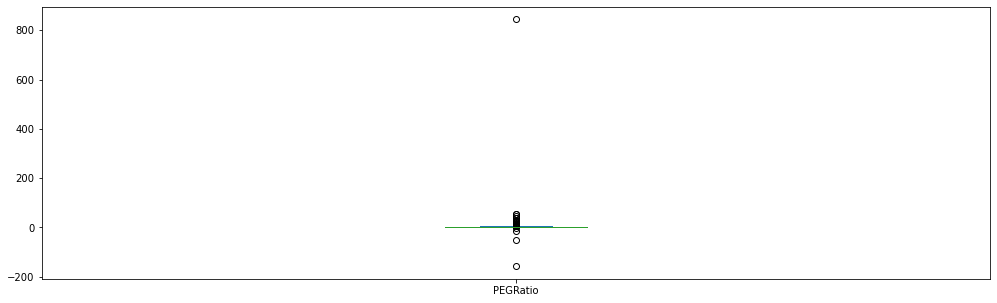

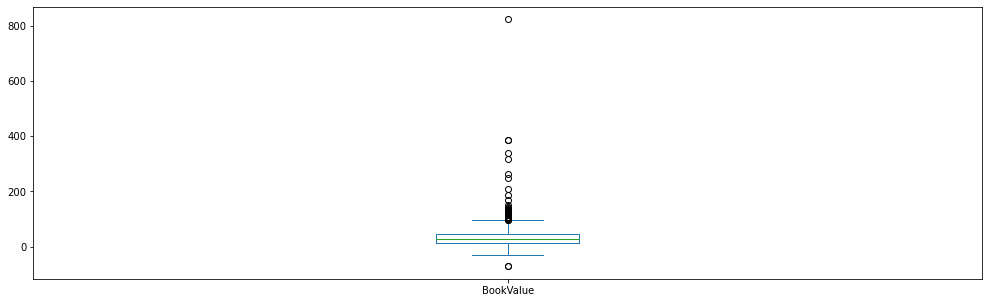

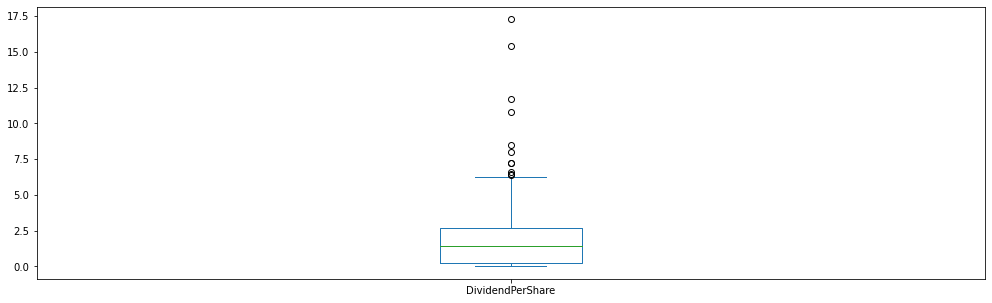

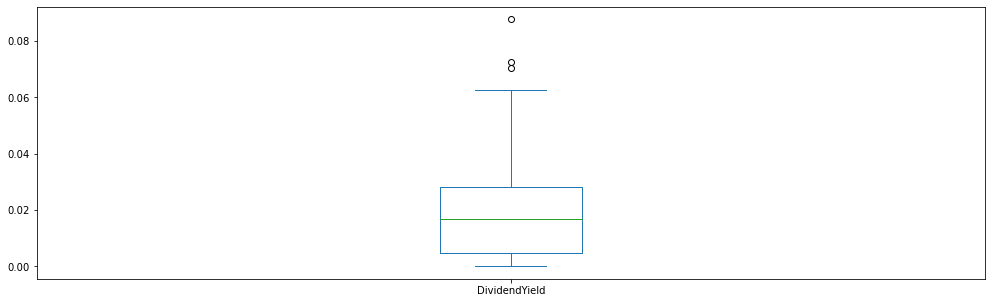

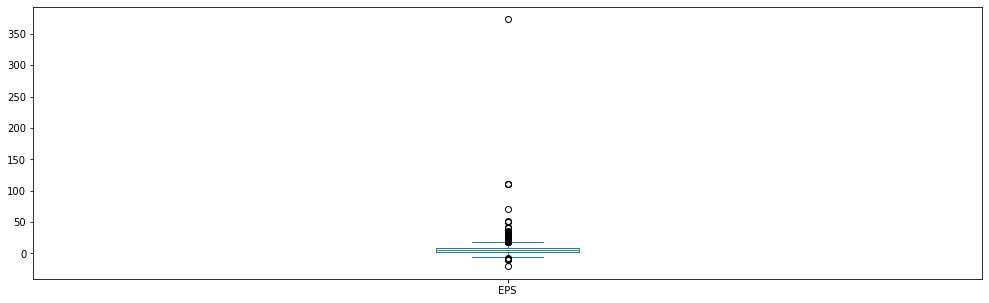

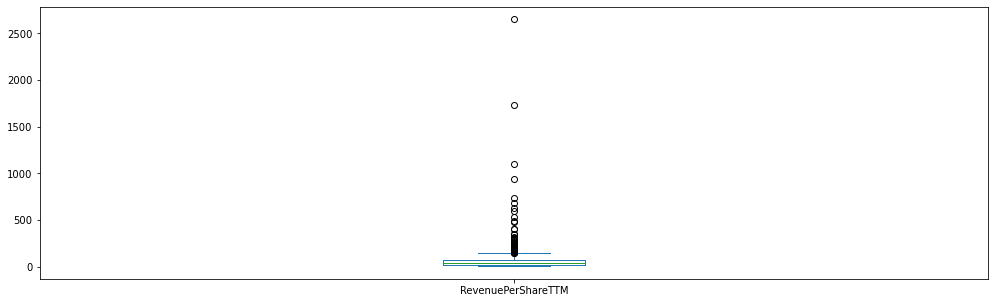

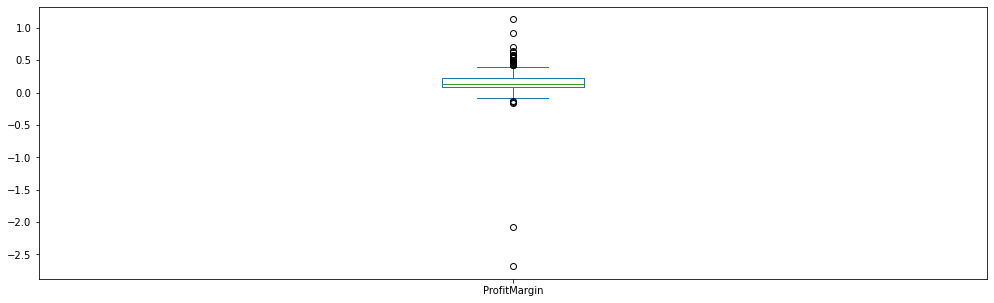

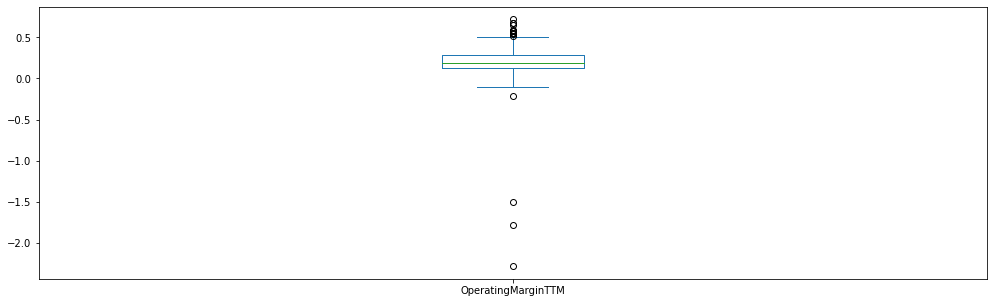

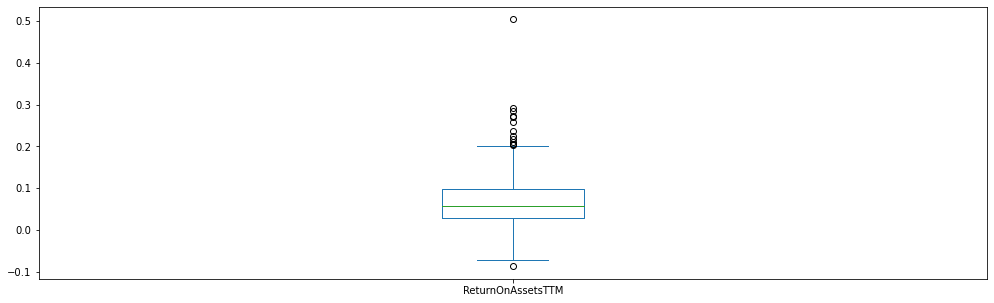

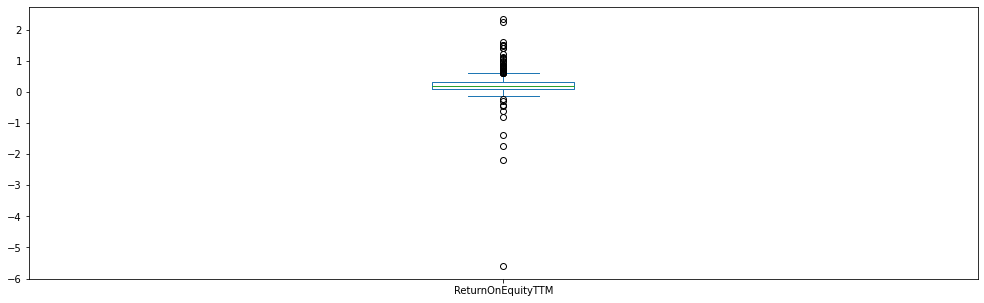

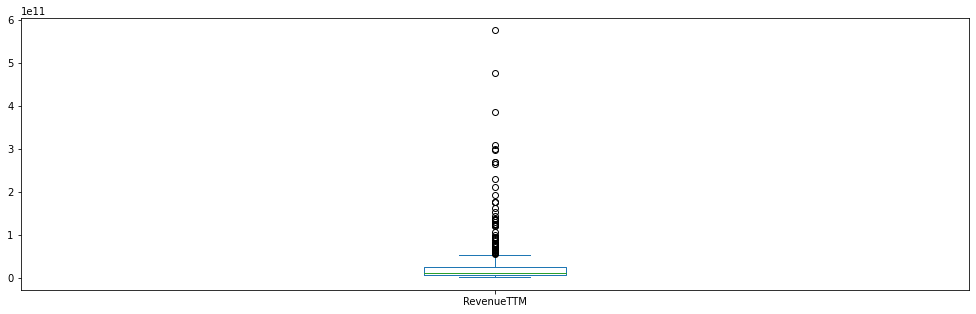

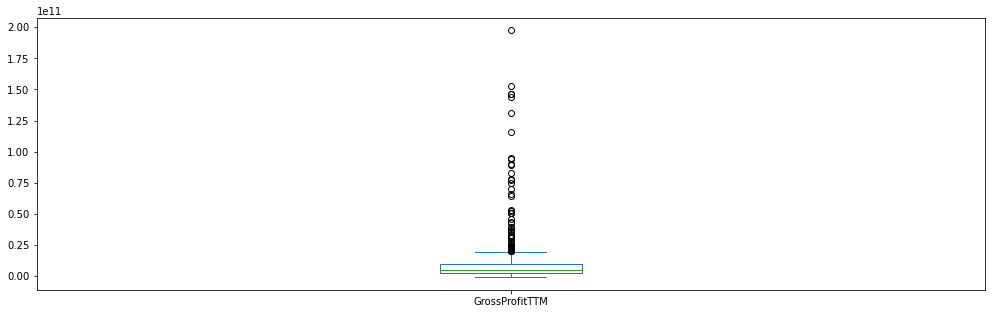

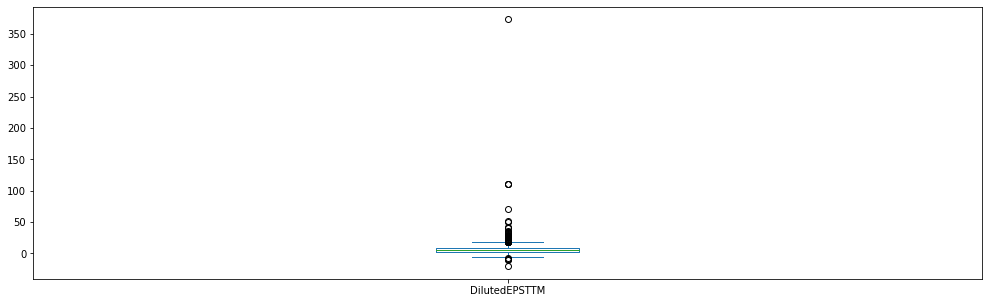

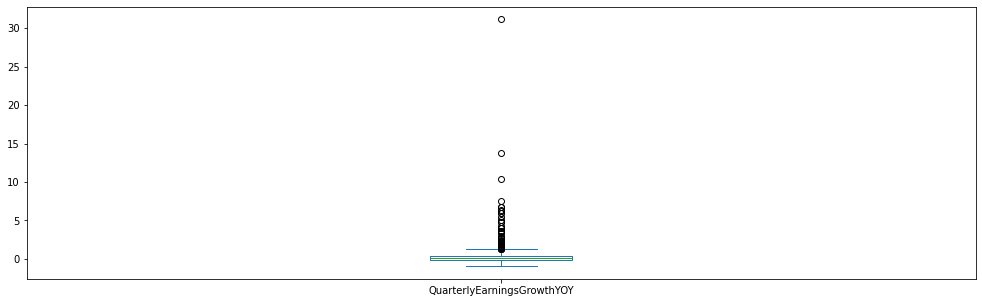

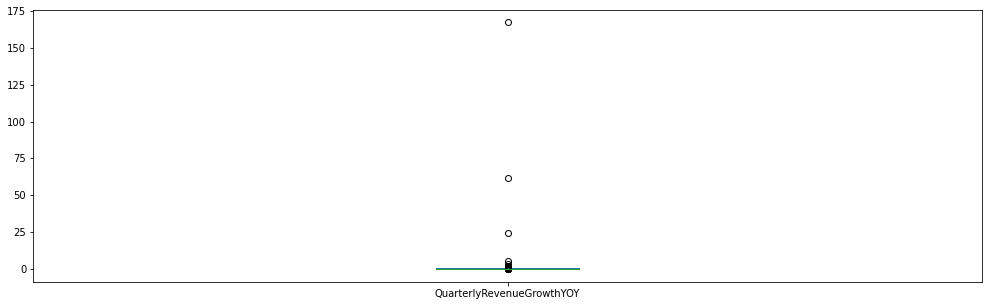

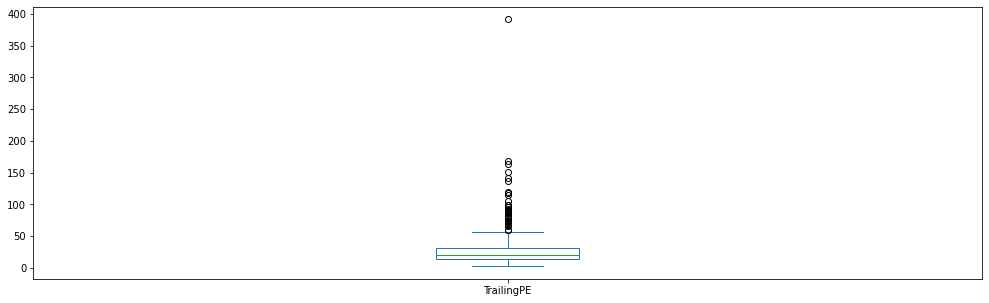

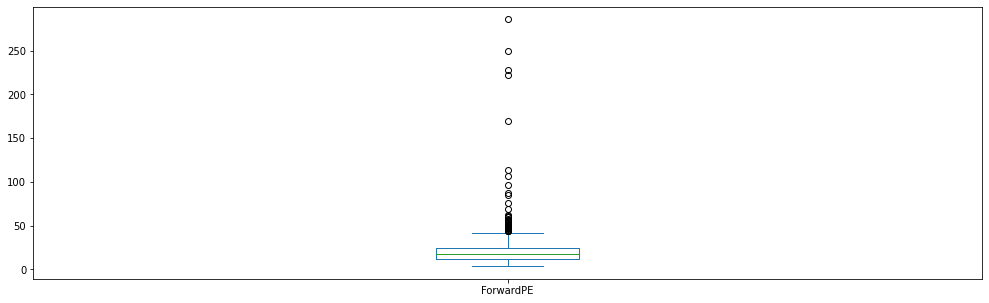

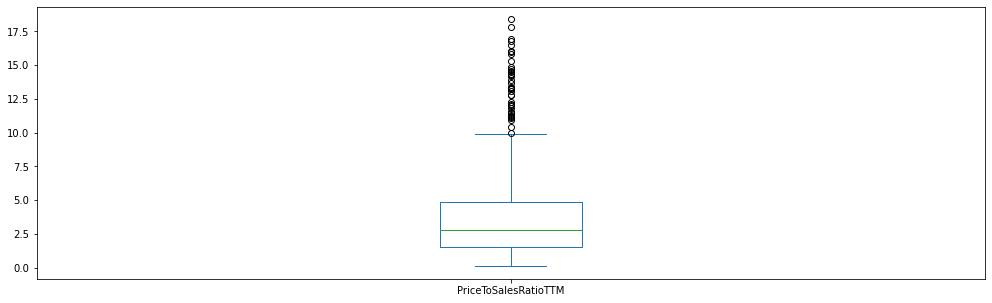

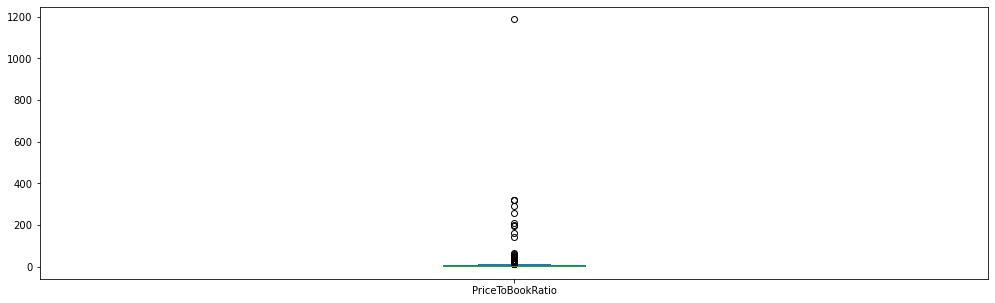

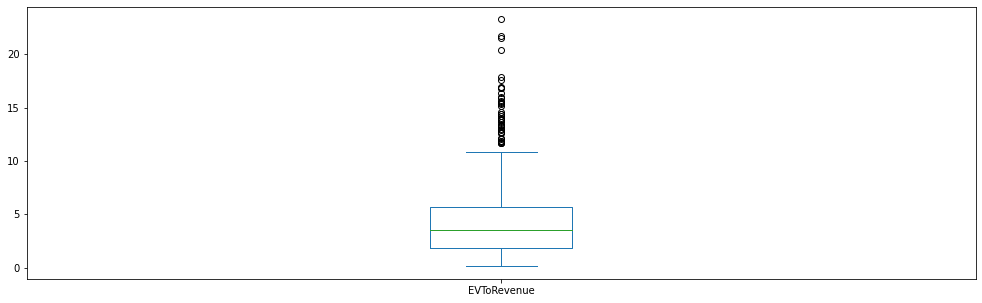

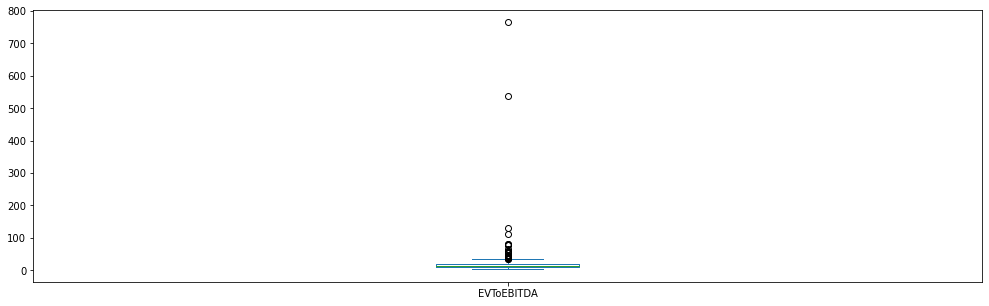

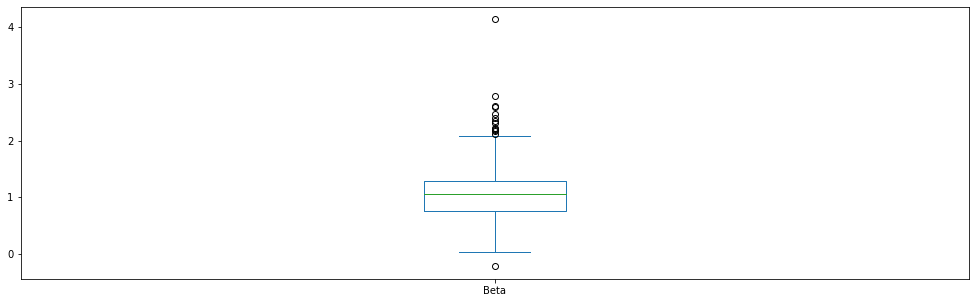

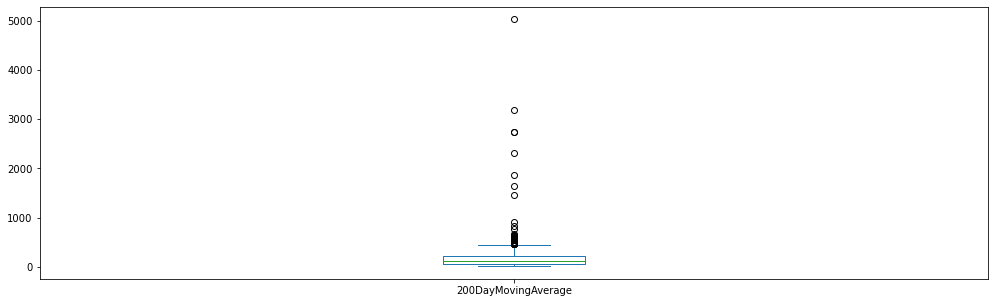

In [149]:
import matplotlib.pyplot as plt
for c in plt_cols:
    df[c].plot(kind='box',subplots=True,figsize=(17,5))
    plt.show()

It is safe to say that this data presents a large number of outliers across multiple features as shown by the box plots and distributions. This needs to be taken into account when we look at the correct model to use. As the authors put it on page 66:

"Some machine learning techniques do not perform well in the presence of outliers, so we should note these in the data quality plan for possible handling later in the project."

The authors also recommend visualizing the relationship between variables using a scatter plot matrix, unfortunately due to the large number of features, this type of visualization is rather hard in jupyter notebook, so I'll move directly to a correlation matrix.

<AxesSubplot:>

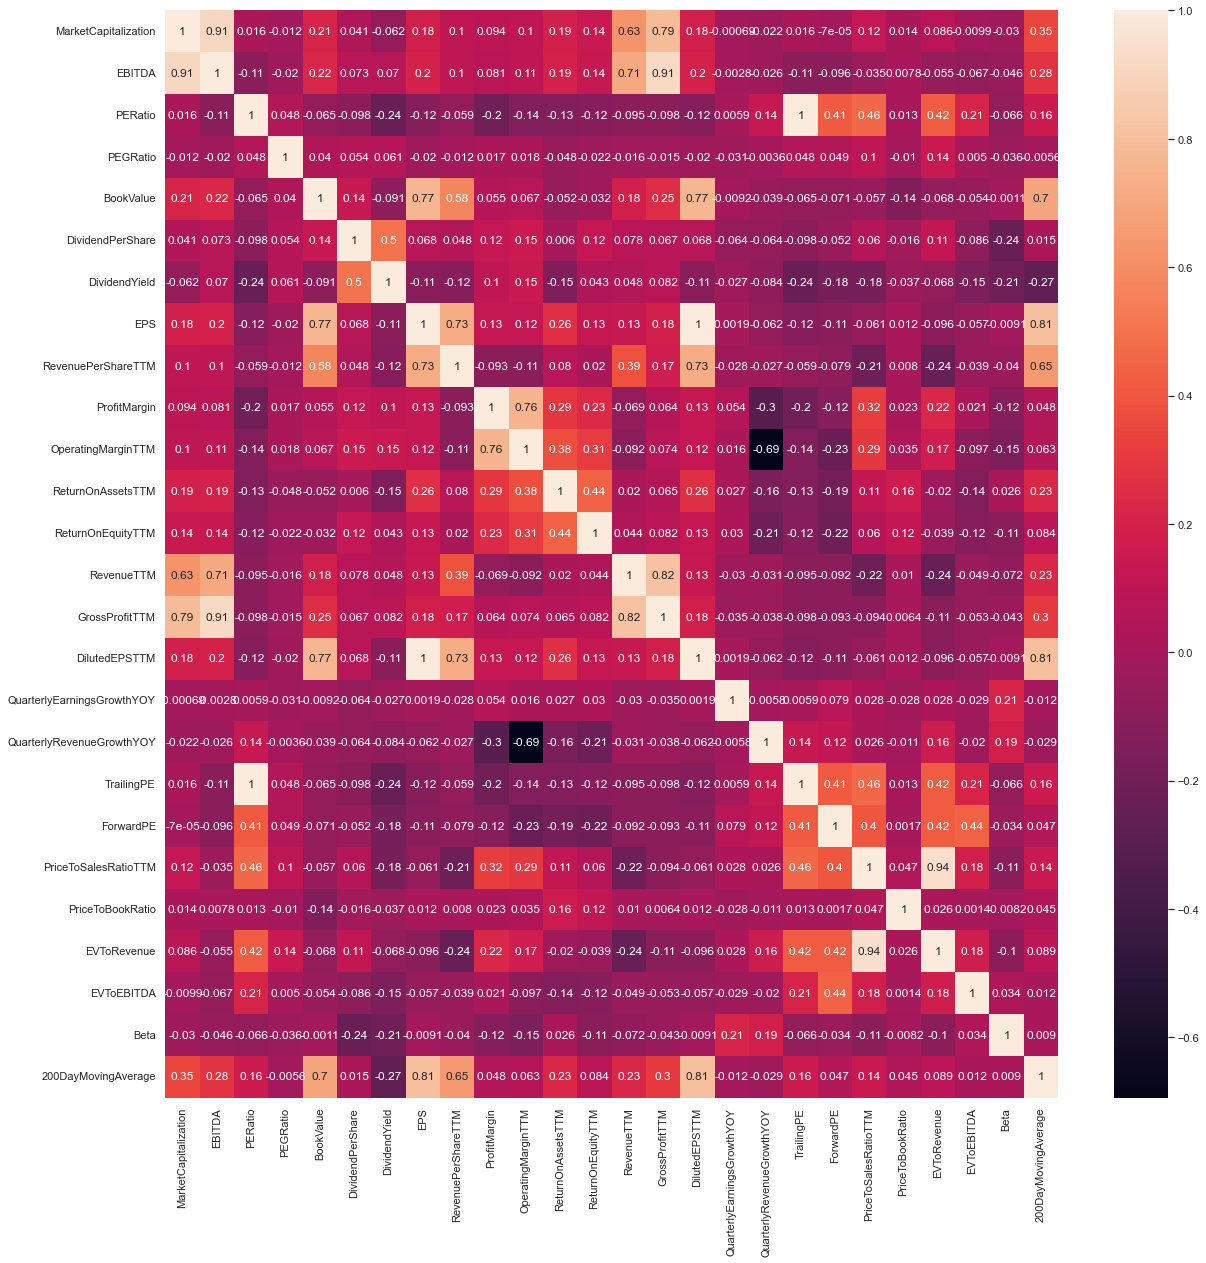

In [151]:
corr_matrix = df.corr()
sn.set(rc = {'figure.figsize':(20,20)})
sn.heatmap(corr_matrix, annot=True)

In [167]:
pos_corr = corr_matrix[ (corr_matrix.iloc[:,:] > .6) & (corr_matrix.iloc[:,:] < 1)  ]
pos_corr = pos_corr.dropna(axis=1,how='all')
pos_corr = pos_corr.dropna(axis=0,how='all')
pos_corr

,MarketCapitalization,EBITDA,BookValue,EPS,RevenuePerShareTTM,ProfitMargin,OperatingMarginTTM,RevenueTTM,GrossProfitTTM,DilutedEPSTTM,PriceToSalesRatioTTM,EVToRevenue,200DayMovingAverage
MarketCapitalization,NaN,0.909372,NaN,NaN,NaN,NaN,NaN,0.625652,0.785417,NaN,NaN,NaN,NaN
EBITDA,0.909372,NaN,NaN,NaN,NaN,NaN,NaN,0.711563,0.914537,NaN,NaN,NaN,NaN
BookValue,NaN,NaN,NaN,0.765432,NaN,NaN,NaN,NaN,NaN,0.765432,NaN,NaN,0.696903
EPS,NaN,NaN,0.765432,NaN,0.728651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.806741
RevenuePerShareTTM,NaN,NaN,NaN,0.728651,NaN,NaN,NaN,NaN,NaN,0.728651,NaN,NaN,0.647448
ProfitMargin,NaN,NaN,NaN,NaN,NaN,NaN,0.759501,NaN,NaN,NaN,NaN,NaN,NaN
OperatingMarginTTM,NaN,NaN,NaN,NaN,NaN,0.759501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RevenueTTM,0.625652,0.711563,NaN,NaN,NaN,NaN,NaN,NaN,0.818397,NaN,NaN,NaN,NaN
GrossProfitTTM,0.785417,0.914537,NaN,NaN,NaN,NaN,NaN,0.818397,NaN,NaN,NaN,NaN,NaN
DilutedEPSTTM,NaN,NaN,0.765432,NaN,0.728651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.806741


In [169]:
pos_corr = corr_matrix[ (corr_matrix.iloc[:,:] > .7) & (corr_matrix.iloc[:,:] < .9)  ]
pos_corr = pos_corr.dropna(axis=1,how='all')
pos_corr = pos_corr.dropna(axis=0,how='all')
pos_corr

,MarketCapitalization,EBITDA,BookValue,EPS,RevenuePerShareTTM,ProfitMargin,OperatingMarginTTM,RevenueTTM,GrossProfitTTM,DilutedEPSTTM,200DayMovingAverage
MarketCapitalization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.785417,NaN,NaN
EBITDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.711563,NaN,NaN,NaN
BookValue,NaN,NaN,NaN,0.765432,NaN,NaN,NaN,NaN,NaN,0.765432,NaN
EPS,NaN,NaN,0.765432,NaN,0.728651,NaN,NaN,NaN,NaN,NaN,0.806741
RevenuePerShareTTM,NaN,NaN,NaN,0.728651,NaN,NaN,NaN,NaN,NaN,0.728651,NaN
ProfitMargin,NaN,NaN,NaN,NaN,NaN,NaN,0.759501,NaN,NaN,NaN,NaN
OperatingMarginTTM,NaN,NaN,NaN,NaN,NaN,0.759501,NaN,NaN,NaN,NaN,NaN
RevenueTTM,NaN,0.711563,NaN,NaN,NaN,NaN,NaN,NaN,0.818397,NaN,NaN
GrossProfitTTM,0.785417,NaN,NaN,NaN,NaN,NaN,NaN,0.818397,NaN,NaN,NaN
DilutedEPSTTM,NaN,NaN,0.765432,NaN,0.728651,NaN,NaN,NaN,NaN,NaN,0.806741


**Features with above a .9 pearsons correlation:**

* PriceToSalesRatioTTM to EVToRevenue
* GrossProfitTTM to EBITDA
* MarketCapitilization to EBITDA

**Features above between .7 and .9:**

* BookValue to 200DayMovingAverage
* EPS to 200DayMovingAverage
* DilutedEPSTTM to 200DayMovingAverage
* RevenuePerShareTTM to 200DayMovingAverage
* RevenueTTM to EBITDA
* RevenuePerShareTTM to EPS
* DilutedEPSTTM to BookValue

**Features below .5 (indicating a negative correaltion)**:
* QuarterlyRevenueGrowthYOY to OperatingMarginTTM

In [153]:
corr_matrix

,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,DividendPerShare,DividendYield,EPS,RevenuePerShareTTM,ProfitMargin,...,QuarterlyEarningsGrowthYOY,QuarterlyRevenueGrowthYOY,TrailingPE,ForwardPE,PriceToSalesRatioTTM,PriceToBookRatio,EVToRevenue,EVToEBITDA,Beta,200DayMovingAverage
MarketCapitalization,1.000000,0.909372,0.016415,-0.012115,0.210364,0.041209,-0.061571,0.184626,0.101758,0.094244,...,-0.000691,-0.021702,0.016415,-0.000070,0.123447,0.014372,0.086464,-0.009900,-0.029628,0.345605
EBITDA,0.909372,1.000000,-0.106341,-0.020444,0.224005,0.072767,0.069807,0.198594,0.104585,0.080859,...,-0.002833,-0.026436,-0.106341,-0.096316,-0.035188,0.007801,-0.055346,-0.067296,-0.045905,0.276073
PERatio,0.016415,-0.106341,1.000000,0.048398,-0.064682,-0.097511,-0.240210,-0.124155,-0.058908,-0.200744,...,0.005886,0.136642,1.000000,0.414425,0.457654,0.013323,0.418822,0.210417,-0.065708,0.155586
PEGRatio,-0.012115,-0.020444,0.048398,1.000000,0.039567,0.054299,0.061447,-0.020456,-0.012216,0.016735,...,-0.031079,-0.003561,0.048398,0.048975,0.100821,-0.010269,0.141353,0.004972,-0.035942,-0.005616
BookValue,0.210364,0.224005,-0.064682,0.039567,1.000000,0.137312,-0.091258,0.765432,0.576182,0.055313,...,-0.009166,-0.038975,-0.064682,-0.071365,-0.056878,-0.142276,-0.067831,-0.054390,-0.001127,0.696903
DividendPerShare,0.041209,0.072767,-0.097511,0.054299,0.137312,1.000000,0.498476,0.067511,0.047551,0.120656,...,-0.063665,-0.063738,-0.097511,-0.051921,0.059775,-0.016395,0.113270,-0.086137,-0.238620,0.015205
DividendYield,-0.061571,0.069807,-0.240210,0.061447,-0.091258,0.498476,1.000000,-0.110357,-0.115946,0.100279,...,-0.026528,-0.083537,-0.240210,-0.178673,-0.181259,-0.037245,-0.068340,-0.154760,-0.205806,-0.269021
EPS,0.184626,0.198594,-0.124155,-0.020456,0.765432,0.067511,-0.110357,1.000000,0.728651,0.128219,...,0.001864,-0.062496,-0.124155,-0.110475,-0.060999,0.012190,-0.095567,-0.056724,-0.009102,0.806741
RevenuePerShareTTM,0.101758,0.104585,-0.058908,-0.012216,0.576182,0.047551,-0.115946,0.728651,1.000000,-0.093025,...,-0.027501,-0.026881,-0.058908,-0.079250,-0.214925,0.008004,-0.239907,-0.038990,-0.040354,0.647448
ProfitMargin,0.094244,0.080859,-0.200744,0.016735,0.055313,0.120656,0.100279,0.128219,-0.093025,1.000000,...,0.054029,-0.303079,-0.200744,-0.121651,0.316670,0.022757,0.219750,0.020619,-0.122126,0.047533


## Citations

John D. Kelleher et al. *Fundamentals of Machine Learning for Predictive Data Analytics*, MIT Press, 2020. https://machinelearningbook.com/teaching-materials/